In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
df = pd.read_pickle('df')
df.head()

,Postal_Code,Unit_Type,Address,Cost,Home_Type,Bedroom_Num,Bathroom_Num,Area_SqFt,Neighborhood,boro_names,median_rent,median_income,car_free_commute,population_density,poverty_rate,crime,subway,park,income_diversity_ratio,labor_force_rate
0,11378.0,1,"6155 60th Pl, Maspeth, NY 11378",2650.0,1,3.0,1.0,1375.0,1,1,2543.07,54870.01,0.78,22.53,0.14,1.766784,0.89,0.79,4.07,0.67
1,11361.0,2,"217th St, Bayside, NY 11361",1250.0,2,0.0,1.0,550.0,2,1,1962.32,61084.74,0.34,12.87,0.07,1.088525,0.21,0.69,4.25,0.63
2,10001.0,1,"247 W 26th St APT 5B, New York, NY 10001",2500.0,3,1.0,1.0,500.0,3,2,3545.57,82393.55,0.89,47.01,0.13,4.959078,0.97,0.71,7.32,0.76
3,10001.0,1,"358 W 30th St APT 2B, New York, NY 10001",2350.0,3,0.0,1.0,NaN,3,2,3545.57,82393.55,0.89,47.01,0.13,4.959078,0.97,0.71,7.32,0.76
4,10001.0,1,"420 W 25th St APT 7K, New York, NY 10001",5900.0,3,1.0,1.0,893.0,3,2,3545.57,82393.55,0.89,47.01,0.13,4.959078,0.97,0.71,7.32,0.76


In [3]:
# ADDING MISSING VALUES -> IS THERE A WAY TO OPTIMIZE THIS CODE?

'''
median_sqft = df.groupby(['Neighborhood'])['Area_SqFt'].median()

for x in range(len(df)):
    if df.Area_SqFt.isnull()[x] == True:
        df.Area_SqFt[x] = median_sqft[df.Neighborhood[x]]
        
'''
df.Bathroom_Num = df.Bathroom_Num.fillna(df.Bathroom_Num.median)
df.Bathroom_Num = pd.to_numeric(df.Bathroom_Num, errors='coerce')

In [4]:
# REMOVING NON NUMERICAL NUMBERS

X = df.drop(columns = ['Address', 'Cost', 'Area_SqFt'])
y = df.Cost
X.shape, y.shape

((5140, 17), (5140,))

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5140 entries, 0 to 5322
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Postal_Code             5140 non-null   float64
 1   Unit_Type               5140 non-null   int32  
 2   Home_Type               5140 non-null   int32  
 3   Bedroom_Num             5140 non-null   float64
 4   Bathroom_Num            5071 non-null   float64
 5   Neighborhood            5140 non-null   int32  
 6   boro_names              5140 non-null   int32  
 7   median_rent             5140 non-null   float64
 8   median_income           5140 non-null   float64
 9   car_free_commute        5140 non-null   float64
 10  population_density      5140 non-null   float64
 11  poverty_rate            5140 non-null   float64
 12  crime                   5140 non-null   float64
 13  subway                  5140 non-null   float64
 14  park                    5140 non-null   

In [6]:
# TRAIN TEST SPLIT

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=47)

### Model 1 - Simple Linear Regression

In [7]:
# DEFINING THE PIPELINE

pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    LinearRegression()
)

In [8]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [9]:
y_pred = pipe.predict(X_test)

In [10]:
mean_absolute_error(y_test, y_pred)

644.7288510406586

In [11]:
r2_score(y_test, y_pred) 

0.438823010822051

- not a very accurate model

### Model 2 - Compex Linear Regression

In [12]:
pipe = make_pipeline( 
    SimpleImputer(strategy='median'),
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [13]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

In [14]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [15]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [16]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001D041B54D30>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17]})

In [17]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [18]:
lr_grid_cv.best_params_

{'selectkbest__k': 17}

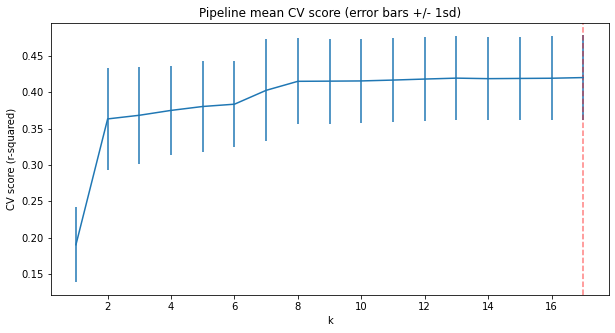

In [19]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [20]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [21]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

median_rent               740.141940
Bathroom_Num              617.588919
Bedroom_Num               326.644365
population_density        320.690361
Neighborhood              122.858657
park                       91.592470
Home_Type                  84.213928
income_diversity_ratio     70.746498
crime                      66.608303
boro_names                 17.034776
Postal_Code                 2.493785
subway                    -45.177878
labor_force_rate          -47.362325
car_free_commute          -71.080813
Unit_Type                 -77.824568
median_income             -93.769954
poverty_rate             -100.990901
dtype: float64

In [22]:
mean_absolute_error(y_test, y_pred)

644.7288510406586

In [23]:
r2_score(y_test, y_pred)

0.438823010822051

- First used the standard f regrssion and it had almost no effect on the model. MAE changed by less than 1!. 

In [24]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [25]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(593.3059327303065, 17.39335440802985)

In [26]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

644.7288510406586

### Model 3 - Random Forest Model

In [27]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [28]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None],
 'simpleimputer__strategy': ['mean', 'median']}

In [29]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [30]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'simpleimputer__strategy': [

In [31]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 379,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

In [32]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.48608372, 0.5667522 , 0.69623271, 0.76594841, 0.55010061])

In [33]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.6130235280290052, 0.10249276176629073)

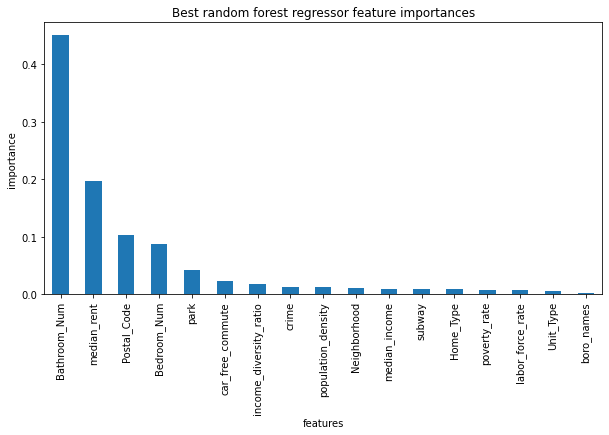

In [34]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [35]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [36]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(425.61972931284527, 25.310871815460747)

In [37]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

418.04246863408343

In [38]:
np.sqrt(mean_squared_error(y_test, rf_grid_cv.best_estimator_.predict(X_test)))

1012.605519762531